### My goals in this notebook will be described as the following:
1. Doing an Explorative Data Analysis (EDA) and document interesting patterns, data issues and ideas.
2) Find a good-fit classification model to predict if a customer will register a payment delay or not. Consider selecting your features and data pre-processing depending on your models used.
3) We have a list (test.csv) of 2,000 customers to asses if they are likely to register payment delays in the following period. Since your action time is limited, you need to extract 300 customers from the list who will then be addressed directly by the company.

**submit the indices [1,2000] of the first 300 customers from the test.csv list which are likely to register payment delays. **

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# We want our plots to appear inside the notebook
%matplotlib inline 

# model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/sample_data/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/sample_data/Data/train.csv
/content/sample_data/Data/test.csv


In [ ]:
df_test = pd.read_csv("/content/sample_data/Data/test.csv")
df_train = pd.read_csv("/content/sample_data/Data/train.csv")
df_train.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,payment_delay
0,HI,33,area_code_415,no,no,0,200.5,117,34.09,159.9,111,13.59,196.2,84,8.83,16.3,6,4.40,3,no
1,TN,80,area_code_415,yes,no,0,276.5,122,47.01,195.6,79,16.63,210.3,78,9.46,7.2,3,1.94,1,yes
2,CT,37,area_code_408,no,no,0,134.9,98,22.93,248.4,130,21.11,236.2,113,10.63,14.7,2,3.97,3,no
3,TN,106,area_code_415,no,no,0,119.2,142,20.26,228.4,139,19.41,197.9,61,8.91,8.4,9,2.27,2,no
4,TX,123,area_code_408,no,no,0,260.9,85,44.35,168.5,103,14.32,178.3,91,8.02,13.3,5,3.59,3,no


In [ ]:
df_train.shape

(3000, 20)

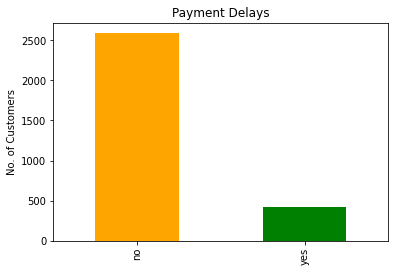

In [ ]:
# Our target column
df_train["payment_delay"].value_counts().plot(kind="bar",
                                              color=['orange', 'green'],
                                             ylabel="No. of Customers",
                                             title="Payment Delays") 

In [ ]:
# Check the dataframe data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          3000 non-null   object 
 1   account_length                 3000 non-null   int64  
 2   area_code                      3000 non-null   object 
 3   international_plan             3000 non-null   object 
 4   voice_mail_plan                3000 non-null   object 
 5   number_vmail_messages          3000 non-null   int64  
 6   total_day_minutes              3000 non-null   float64
 7   total_day_calls                3000 non-null   int64  
 8   total_day_charge               3000 non-null   float64
 9   total_eve_minutes              3000 non-null   float64
 10  total_eve_calls                3000 non-null   int64  
 11  total_eve_charge               3000 non-null   float64
 12  total_night_minutes            3000 non-null   f

In [ ]:
# Looking for null values, 0 means excellent :)
df_train.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
payment_delay                    0
dtype: int64

In [ ]:
df_train.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,100.510000,7.977333,180.456533,100.228667,30.678167,200.034000,100.247333,17.003100,201.099633,99.939667,9.049577,10.206500,4.495333,2.756263,1.591667
std,39.485782,13.730125,54.098371,19.763769,9.196706,50.127406,19.761638,4.260769,50.863770,19.669680,2.288908,2.749696,2.489051,0.742311,1.314346
min,1.000000,0.000000,0.000000,0.000000,0.000000,22.300000,12.000000,1.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.700000,87.000000,24.430000,165.800000,87.000000,14.090000,166.975000,87.000000,7.517500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,179.400000,101.000000,30.500000,199.900000,101.000000,16.990000,201.600000,100.000000,9.070000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,18.000000,216.800000,113.000000,36.860000,233.700000,113.000000,19.860000,235.225000,113.000000,10.582500,12.000000,6.000000,3.240000,2.000000
max,233.000000,52.000000,346.800000,165.000000,58.960000,363.700000,169.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


### After a short visual analysis I decided to take each column and compare it with payment_delays in the hope of finding some factors that influence this action of customers who use the company's services. 
##### The most influential factors found below are:
1. The vast majority of users who do not have an international_plan are more likely to meet their payment deadline.
2. The total number of international calls is an subjective number and the predisposition to non-payment of services depends on the needs of each individual.
3. Individuals with a daily charge of more than 50 minutes are more likely to be late for payment.
4. Some individuals with 0 number of voicemail messages are more open to payment delay, maybe they really don't use this services or they have no one / they are alone.

In [ ]:
# Customers churn frequency according to international_plan
df_train['international_plan'].value_counts()

no     2719
yes     281
Name: international_plan, dtype: int64

In [ ]:
# Compare our target column with international_plan column
pd.crosstab(df_train.payment_delay, df_train.international_plan)

international_plan,no,yes
payment_delay,,
no,2422,165
yes,297,116


In [ ]:
pd.crosstab(df_train.payment_delay, df_train.total_intl_calls)

total_intl_calls,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
payment_delay,,,,,,,,,,,,,,,,,,,,
no,13,124,335,525,498,389,261,161,97,73,48,19,17,12,3,5,3,2,2,0
yes,1,27,89,79,65,47,38,27,9,11,8,4,2,0,1,3,0,0,1,1


1. We can see that those with a daily charge of more than 50 minutes are more likely to be late for payment.

In [ ]:

# pd.crosstab(df_train.payment_delay, df_train.total_day_calls)
pd.crosstab(df_train.payment_delay, df_train.total_day_charge)

total_day_charge,0.00,0.44,1.12,1.34,2.13,2.99,3.21,3.32,4.40,4.59,...,55.13,55.34,55.44,55.51,55.78,56.07,56.46,56.83,58.70,58.96
payment_delay,,,,,,,,,,,,,,,,,,,,,
no,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
yes,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
# Total charge based on area codes

df_train['total_charge'] = df_train['total_day_charge'] + df_train['total_eve_charge'] + df_train['total_night_charge'] + df_train['total_intl_charge']
df_test['total_charge'] = df_test['total_day_charge'] + df_test['total_eve_charge'] + df_test['total_night_charge'] + df_test['total_intl_charge']
fig = px.pie(df_train, values='total_charge', names='area_code')
fig.show()

The most charged customers are from area code: 415

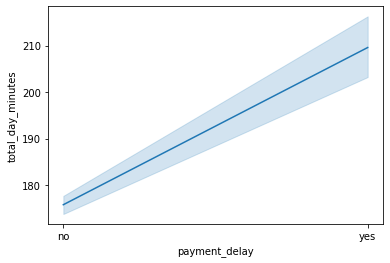

In [ ]:
# Seaborn lineplot of `Total daily minutes` for all category in `Payment delays`

sns.lineplot(x="payment_delay", y="total_day_minutes", data=df_train);

In [ ]:
# pd.crosstab(df_train.payment_delay, df_train.account_length)
pd.crosstab(df_train.payment_delay, df_train.number_vmail_messages)

number_vmail_messages,0,4,6,8,10,11,12,13,14,15,...,42,43,44,45,46,47,48,49,51,52
payment_delay,,,,,,,,,,,,,,,,,,,,,
no,1838,1,1,1,3,2,5,3,3,9,...,7,11,4,5,7,4,1,2,1,1
yes,351,0,0,0,0,0,0,0,0,1,...,3,0,2,1,0,0,1,0,0,0


In [ ]:
# Account length according to payment delay

fig = px.box(df_train, x="payment_delay", y=['account_length'], points="all")
fig.show()

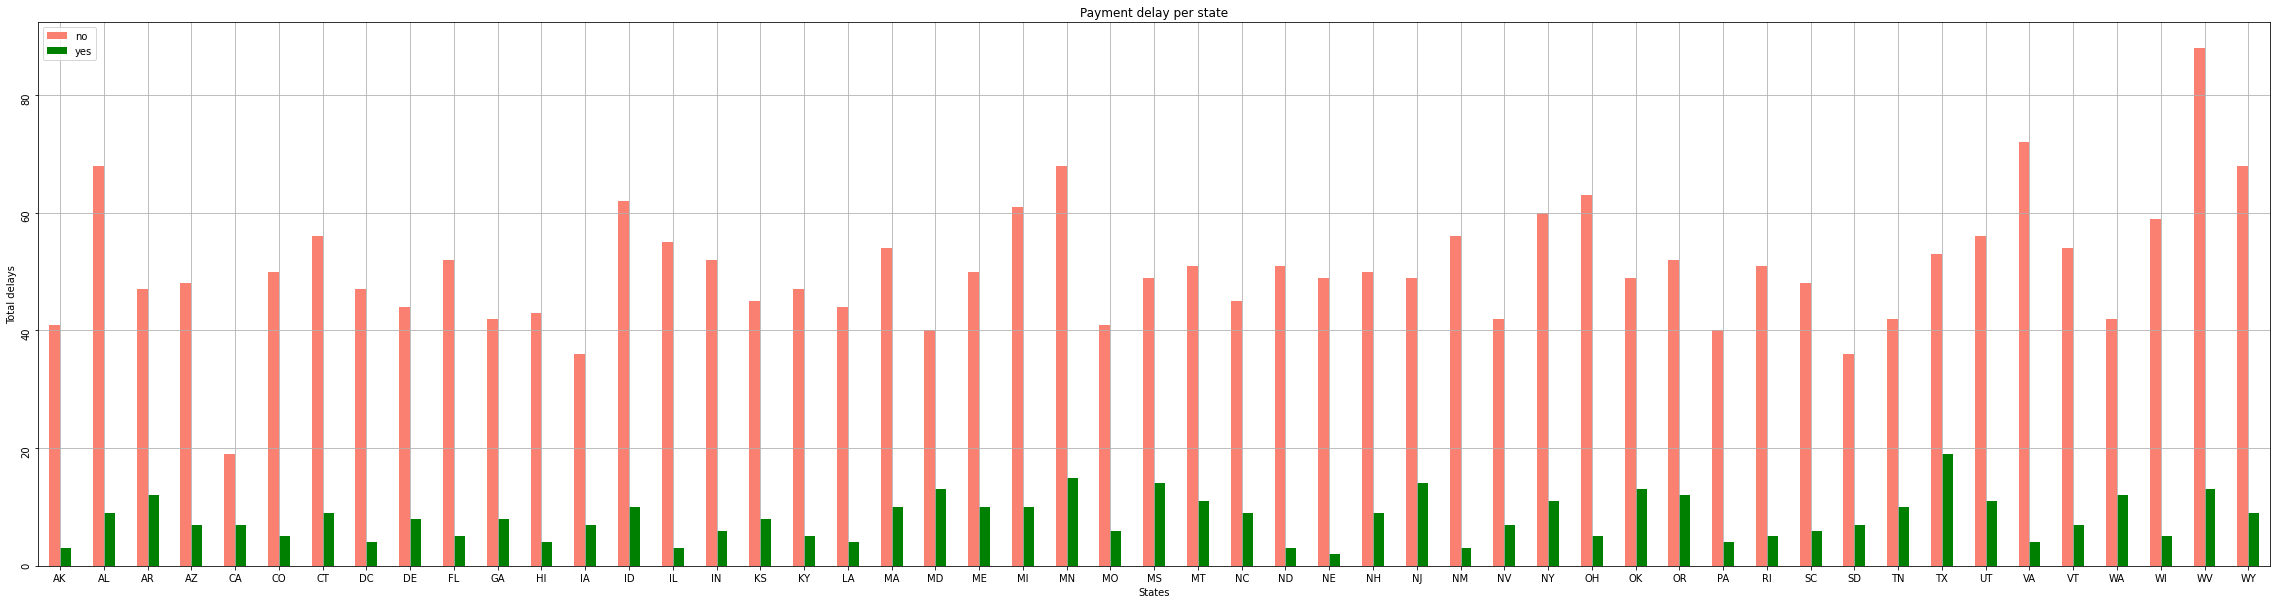

In [ ]:
# Payment delay per state

pd.crosstab(df_train.state, df_train.payment_delay).plot(
    kind='bar',
    color=['salmon', 'green'],
    figsize=(40,10),
    grid=True)

plt.title("Payment delay per state")
plt.xlabel("States")
plt.ylabel("Total delays")
plt.legend(["Y", "N"])
plt.xticks(rotation = 0)
plt.yticks(rotation = 90)
plt.legend(loc="upper left")

This plot looks not so good, I will try something else, more intuitive.
Plotly will help me with this figure.

In [ ]:
img=[]
for name,group in df_train.groupby(['state','payment_delay']):
    img.append([name[1],name[0],group.shape[0]])
    
df_state_count=pd.DataFrame(img)
df_state_count.columns=['payment_delay','state','count']
px.bar(df_state_count,x='state',y='count',color='payment_delay')

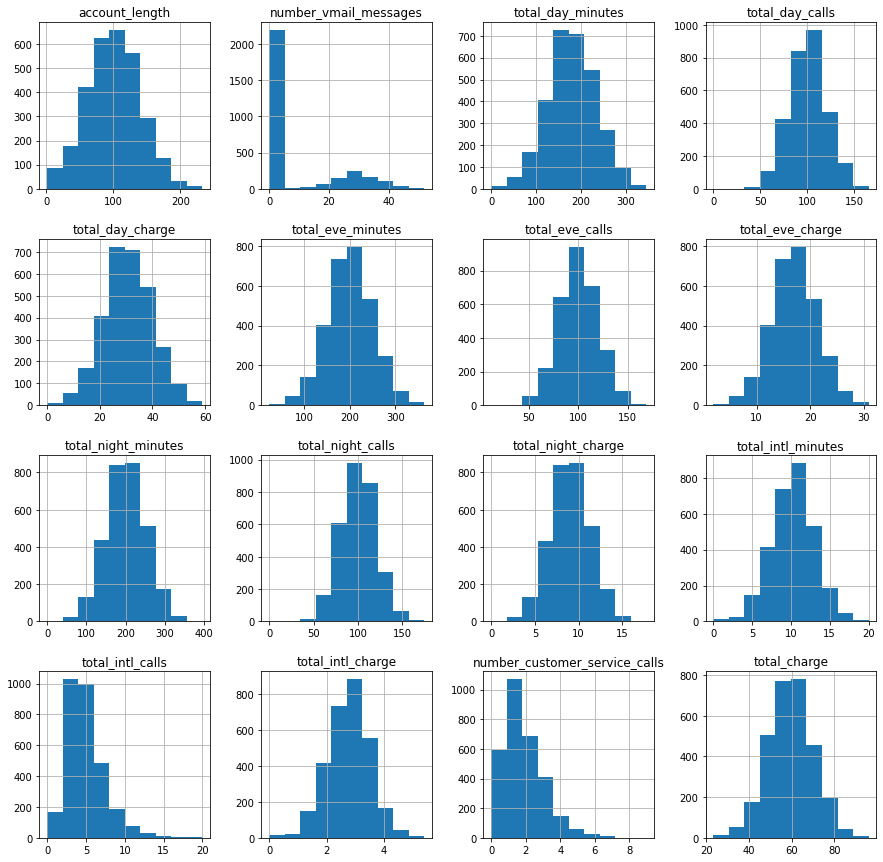

In [ ]:
# Also in pandas we can plot histogram for all features 
df_train.hist(figsize=(15,15));

In [ ]:
# Make a correlation matrix

df_train.corr()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,total_charge
account_length,1.000000,-0.053027,-0.003457,0.023510,-0.003461,-0.008875,-0.007510,-0.008860,-0.002266,-0.003619,-0.002288,0.015526,0.009690,0.015551,-0.000233,-0.006072
number_vmail_messages,-0.053027,1.000000,0.014207,0.007241,0.014195,0.006555,-0.006489,0.006572,0.000001,-0.020136,0.000019,0.000181,-0.003994,0.000289,-0.013780,0.015239
total_day_minutes,-0.003457,0.014207,1.000000,0.012402,1.000000,-0.004703,0.007082,-0.004704,0.029449,-0.012539,0.029408,-0.033342,0.005317,-0.033214,0.001566,0.884658
total_day_calls,0.023510,0.007241,0.012402,1.000000,0.012402,-0.006429,0.026555,-0.006420,-0.003203,-0.028160,-0.003205,0.021987,0.012745,0.022070,-0.005236,0.009188
total_day_charge,-0.003461,0.014195,1.000000,0.012402,1.000000,-0.004704,0.007077,-0.004705,0.029445,-0.012537,0.029404,-0.033347,0.005311,-0.033219,0.001562,0.884656
total_eve_minutes,-0.008875,0.006555,-0.004703,-0.006429,-0.004704,1.000000,-0.008810,1.000000,-0.019995,0.011491,-0.019981,0.004623,0.006184,0.004720,-0.012501,0.400646
total_eve_calls,-0.007510,-0.006489,0.007082,0.026555,0.007077,-0.008810,1.000000,-0.008802,0.007539,0.005362,0.007583,-0.012345,0.000003,-0.012401,-0.021812,0.003429
total_eve_charge,-0.008860,0.006572,-0.004704,-0.006420,-0.004705,1.000000,-0.008802,1.000000,-0.020017,0.011489,-0.020004,0.004622,0.006193,0.004720,-0.012533,0.400641
total_night_minutes,-0.002266,0.000001,0.029449,-0.003203,0.029445,-0.019995,0.007539,-0.020017,1.000000,0.012387,0.999999,0.007447,-0.004269,0.007457,0.007716,0.237969
total_night_calls,-0.003619,-0.020136,-0.012539,-0.028160,-0.012537,0.011491,0.005362,0.011489,0.012387,1.000000,0.012346,-0.015764,0.001830,-0.015878,-0.004474,-0.004786


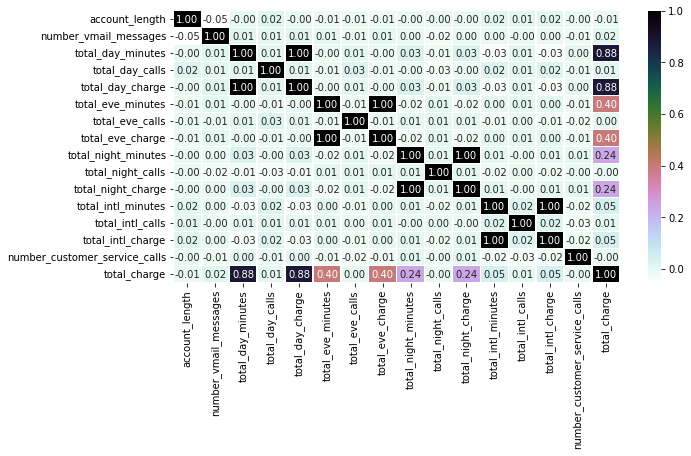

In [ ]:
# Little prettier correlation matrix

c_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(c_matrix,
                annot = True, 
                linewidth= 0.5,
                fmt='.2f',
                cmap="cubehelix_r")

Some features are correlated to each other and have a high coefficient.
Total day minutes and total day charge are directly related because their coeff is 1.

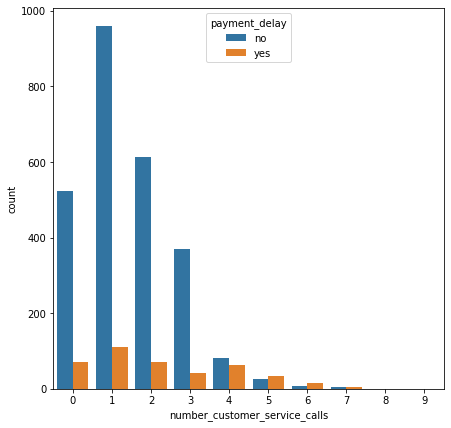

In [ ]:
# Define size of plot 
plt.figure(figsize=(7,7))

sns.countplot(x="number_customer_service_calls", hue="payment_delay", data=df_train);

**Some insights from this EDA observation:
1) Texas has highest number of churns (19).
2) Churned customers have called more for customer service. Customer service can be improved to retain such customers.



## Preparing data for training process 

In [ ]:

df_train['payment_delay'].replace(['no','yes'],[0,1],inplace=True)
df_train['international_plan'].replace(['no','yes'],[0,1],inplace=True)
df_train['area_code'].replace(['area_code_415', 'area_code_510', 'area_code_408'],[415,510,408],inplace=True)

df_test['international_plan'].replace(['no','yes'],[0,1],inplace=True)
df_test['area_code'].replace(['area_code_415', 'area_code_510', 'area_code_408'],[415,510,408],inplace=True)
encoder = LabelEncoder()
voice_train = encoder.fit_transform(df_train['voice_mail_plan'])
df_train['voice_mail_plan'] = voice_train

voice_test = encoder.transform(df_test['voice_mail_plan'])
df_test['voice_mail_plan'] = voice_test

In [ ]:
# Total day minutes and Total day charge are directly related because their coefficient is 1 hence
# I will delete all the columns with the minutes because are redundant,
# and state column because the client's residence does not interst us, as it is subjetive. Coresponing to conf. matrix

df_train.drop(['total_day_minutes','total_eve_minutes','total_night_minutes', 'total_intl_minutes', 'state'], inplace=True,axis=1)
df_test.drop(['total_day_minutes','total_eve_minutes','total_night_minutes', 'total_intl_minutes', 'state'], inplace=True,axis=1)

In [ ]:
df_train.head(5), df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 3000 non-null   int64  
 1   area_code                      3000 non-null   int64  
 2   international_plan             3000 non-null   int64  
 3   voice_mail_plan                3000 non-null   int64  
 4   number_vmail_messages          3000 non-null   int64  
 5   total_day_calls                3000 non-null   int64  
 6   total_day_charge               3000 non-null   float64
 7   total_eve_calls                3000 non-null   int64  
 8   total_eve_charge               3000 non-null   float64
 9   total_night_calls              3000 non-null   int64  
 10  total_night_charge             3000 non-null   float64
 11  total_intl_calls               3000 non-null   int64  
 12  total_intl_charge              3000 non-null   f

(   account_length  area_code  international_plan  voice_mail_plan  \
 0              33        415                   0                0   
 1              80        415                   1                0   
 2              37        408                   0                0   
 3             106        415                   0                0   
 4             123        408                   0                0   
 
    number_vmail_messages  total_day_calls  total_day_charge  total_eve_calls  \
 0                      0              117             34.09              111   
 1                      0              122             47.01               79   
 2                      0               98             22.93              130   
 3                      0              142             20.26              139   
 4                      0               85             44.35              103   
 
    total_eve_charge  total_night_calls  total_night_charge  total_intl_calls  \
 0       

In [ ]:
%%time 
 # Calculate how much time this particular cell takes to run
# Instantiate model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs = -1,
                             random_state = 42)
# Fit the model
model.fit(df_train.drop("payment_delay", axis = 1), df_train["payment_delay"])

CPU times: user 2.22 s, sys: 26.1 ms, total: 2.25 s
Wall time: 1.26 s


In [ ]:
# Score the model

model.score(df_train.drop("payment_delay", axis = 1), df_train["payment_delay"])

0.9714160296734183

**this high score is because we evaluate our model on the same data that our model learns from

In [ ]:
# Split the data into train/validation set

df_val = df_train[2600:]
shrink_df_train = df_train[0:2600]

len(df_val), len(shrink_df_train)

(400, 2600)

In [ ]:
# Split data into X and y

X_train, y_train = shrink_df_train.drop("payment_delay", axis = 1), shrink_df_train["payment_delay"]

X_valid, y_valid = df_val.drop("payment_delay", axis = 1), df_val["payment_delay"]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2600, 15), (2600,), (400, 15), (400,))

### Building an evaluation function

In [ ]:
# Create Root Mean Squared Error evaluation funtion
from sklearn.metrics import mean_squared_log_error, r2_score, mean_absolute_error

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create funtion to evalute model on a few diffrent levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
             "Valid MAE": mean_absolute_error(y_valid, val_preds),
             "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)
             }
    return scores

In [ ]:
model = RandomForestRegressor(n_jobs = -1,
                             random_state = 42,
                             max_samples = 2600)
model

RandomForestRegressor(max_samples=2600, n_jobs=-1, random_state=42)

In [ ]:
%%time

model.fit(X_train, y_train)

CPU times: user 1.92 s, sys: 12.4 ms, total: 1.93 s
Wall time: 1.07 s


RandomForestRegressor(max_samples=2600, n_jobs=-1, random_state=42)

In [ ]:
show_scores(model)

{'Training MAE': 0.018653846153846153,
 'Training RMSLE': 0.03716614449471476,
 'Training R^2': 0.9717494777126008,
 'Valid MAE': 0.058475,
 'Valid RMSLE': 0.1282066648751912,
 'Valid R^2': 0.7409417221213954}

In [ ]:
%%time

# Hyperparameter tuning with RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(1,10),
          "max_depth": [None, 3, 5, 10],
          "min_samples_leaf": np.arange(1,16,2),
          "max_features": ["sqrt","auto"]}
        

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1,
                                                   random_state = 42),
                                                   param_distributions = rf_grid,
                                                   n_iter = 10,
                                                   cv = 5,
                                                   verbose = True)
# Fit the model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 1.53 s, sys: 155 ms, total: 1.68 s
Wall time: 7.83 s


In [ ]:
# Find the best hyperparameters
rs_model.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'n_estimators': 1}

In [ ]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 0.03757746451637853,
 'Training RMSLE': 0.10101418953110013,
 'Training R^2': 0.8225755020838796,
 'Valid MAE': 0.04813266716943186,
 'Valid RMSLE': 0.12401257706985937,
 'Valid R^2': 0.7437849689884246}

In [ ]:
%%time

# Train a model with the best hyperparameters
ideal_model = RandomForestRegressor(n_estimators = 7,
                                   min_samples_leaf = 13,
                                   max_features = 'auto',
                                   n_jobs = -1,
                                   max_depth = 5,
                                   random_state = 42)# random state so our results are reproducibles
# Fit the model
ideal_model.fit(X_train, y_train)

CPU times: user 77.2 ms, sys: 871 µs, total: 78.1 ms
Wall time: 115 ms


In [ ]:
# Scores for ideal_model
show_scores(ideal_model)

{'Training MAE': 0.04394909283261986,
 'Training RMSLE': 0.09779497319719073,
 'Training R^2': 0.8308449895913169,
 'Valid MAE': 0.05272742976051826,
 'Valid RMSLE': 0.11824470251514055,
 'Valid R^2': 0.765953071850034}

In [ ]:
df_test.head()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,number_customer_service_calls,total_charge
0,36,408,0,1,30,128,24.87,80,13.81,109,5.82,6,3.92,0,48.42
1,104,408,0,0,0,106,47.33,113,6.89,137,7.34,5,2.65,1,64.21
2,126,415,0,0,0,94,9.89,118,11.79,91,6.16,1,3.21,5,31.05
3,130,415,0,0,0,101,41.23,114,8.74,89,6.41,2,2.51,2,58.89
4,78,510,0,0,0,88,32.35,89,16.53,109,11.54,5,3.16,2,63.58


In [ ]:
# Make predictions on test data
test_preds = ideal_model.predict(df_test)
len(test_preds)

2000

In [ ]:
top_df = pd.DataFrame(test_preds)

In [ ]:
top_df.head(2)

,0
0,0.027761
1,0.018799


In [ ]:
# Format predictions 
df_preds = pd.DataFrame()
df_preds['Test data index'] = df_test.index
df_preds['Predicted churn'] = test_preds
df_preds

,Test data index,Predicted churn
0,0,0.027761
1,1,0.018799
2,2,1.000000
3,3,0.022132
4,4,0.023884
...,...,...
1995,1995,0.039974
1996,1996,0.026952
1997,1997,0.040260
1998,1998,0.027761


In [ ]:
df_preds['Predicted churn'] = df_preds['Predicted churn'].sort_values(ascending=True, kind='mergesort')
df_preds['Test data index'] = df_preds['Test data index'].sort_values(ascending=True)

In [ ]:
top_pred = df_preds.head(300)

In [ ]:
# Exporting results to csv
pd.DataFrame(top_pred).to_csv("/content/sample_data/Data/churn_predicted.csv",
                              header = 'Predicted Churn',
                              index=False)

In [ ]:
# Find feature importance of our best model
len(ideal_model.feature_importances_)

15

In [ ]:
# Helper function for plotting feature importance

def plot_features(columns, importances, n=20):
    df = (pd.DataFrame ({'features': columns,
                        'feature_importances': importances})
         .sort_values('feature_importances', ascending = False)
         .reset_index(drop=True))
    
    # plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

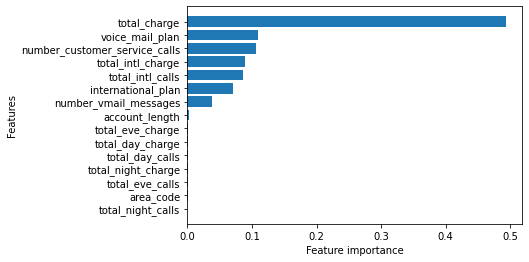

In [ ]:
plot_features(X_train.columns, ideal_model.feature_importances_)